# IML Project
### Yanis Farhat and Benjamin Clene
#### Project conducted through pair programming

The goal of this project is to obtain a pixel classifier.

To achieve this, we have at our disposal two images: an hyperspectral image and a lidar image.

In this notebook, we will create a model and train it using a portion of the hyperspectral image and a portion of the lidar image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import io

First, we will import the data to train the model.

In [2]:
data = sp.io.loadmat('data/2013_DFC_contest.mat')

lidar = data['lidar'].copy()
print("The LiDAR image is composed of %d rows and %d columns "%(lidar.shape)+"in the %s format"%lidar.dtype)
hsi_raw = data['hyper'].copy()
print("The hyperspectral image is composed of %d rows, %d columns, and %d bands "%(hsi_raw.shape)
      +"in the %s format"%hsi_raw.dtype)

The LiDAR image is composed of 349 rows and 1905 columns in the float32 format
The hyperspectral image is composed of 349 rows, 1905 columns, and 144 bands in the uint16 format


Next, we load the ground truth.

In [3]:
groundtruth = np.load('groundtruth/groundtruth.npy')
groundtruth_info = np.load('groundtruth/groundtruth_info.npy',allow_pickle=True)
groundtruth_rgb = plt.imread('groundtruth/groundtruth.png')

In [4]:
groundtruth_info

array([{'class_name': 'grass_healthy', 'class_label': 1, 'class_color': array([  0, 205,   0], dtype=int64)},
       {'class_name': 'grass_stressed', 'class_label': 2, 'class_color': array([127, 255,   0], dtype=int64)},
       {'class_name': 'grass_synthetic', 'class_label': 3, 'class_color': array([ 46, 205,  87], dtype=int64)},
       {'class_name': 'tree', 'class_label': 4, 'class_color': array([  0, 139,   0], dtype=int64)},
       {'class_name': 'soil', 'class_label': 5, 'class_color': array([160,  82,  45], dtype=int64)},
       {'class_name': 'water', 'class_label': 6, 'class_color': array([  0, 255, 255], dtype=int64)},
       {'class_name': 'residential', 'class_label': 7, 'class_color': array([255, 255, 255], dtype=int64)},
       {'class_name': 'commercial', 'class_label': 8, 'class_color': array([216, 191, 216], dtype=int64)},
       {'class_name': 'road', 'class_label': 9, 'class_color': array([255,   0,   0], dtype=int64)},
       {'class_name': 'highway', 'class_label':

We prepare the hyperspectral data before normalization to visualize the original image later.

In [5]:
rgb_bands = [54,32,18]
hsi_rgb = hsi_raw[:,:,rgb_bands]
hsi_rgb = hsi_rgb/hsi_rgb.max() # Normalization of values to [0,1] for display
pmin,pmax = np.percentile(hsi_rgb,(1,95),axis=(0,1))
hsi_rgb_pimped = hsi_rgb.copy()
for i in range(pmin.size):
    hsi_rgb_pimped[:,:,i] = (hsi_rgb[:,:,i]-pmin[i])/(pmax[i]-pmin[i])
hsi_rgb_pimped[hsi_rgb_pimped<0] = 0
hsi_rgb_pimped[hsi_rgb_pimped>1] = 1

We normalize the data, achieving better results with this normalization.

In [6]:
#normalize hsi_raw
hsi_raw = hsi_raw.astype(np.float64)
for i in range (hsi_raw.shape[0]):
    for j in range(hsi_raw.shape[1]):
        X = hsi_raw[i][j]
        if np.any(X != 0):
            hsi_raw[i][j] = (X - X.min()) / (X.max() - X.min())

#normalize lidar
lidar = lidar.astype(np.float64)
lidarMin = lidar.min()
lidarMax = lidar.max()
for i in range (lidar.shape[0]):
    for j in range(lidar.shape[1]):
        X = lidar[i][j]
        if np.any(X != 0):
            lidar[i][j] = (X - lidarMin) / (lidarMax - lidarMin)

We prepare the test data by merging lidar and hyperspectral data.

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


hsi_raw = hsi_raw
lidar = lidar
r,c,N = hsi_raw.shape
hsi = hsi_raw.reshape(r*c,N)

#fusion lidar and hsi for the whole image
allData = np.concatenate((hsi, lidar.reshape(-1, 1)), axis=1)

# we take only pixels with a grountruth known
hsi_train = hsi_raw[groundtruth != 0]
lidar_train = lidar[groundtruth != 0]

# fusion lidar and hsi sets
x_train = np.concatenate((hsi_train, 10*lidar_train.reshape(-1, 1)), axis=1)
y_train = groundtruth[groundtruth != 0]

#check shapes
allData.shape, hsi_train.shape, lidar_train.shape, x_train.shape, y_train.shape

((664845, 145), (2832, 144), (2832,), (2832, 145), (2832,))

We create a validation dataset from the training dataset.

In [8]:
#### from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

We train a model of type RandomForestClassifier as it achieves the best score.

The score varies depending on the data distribution by the train_test_split function.

In [9]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


classifier = RandomForestClassifier(max_depth=16, random_state=1, n_estimators=50, n_jobs=-1)
classifier = classifier.fit(x_train, y_train)
score = classifier.score(x_val, y_val)

print("score: ", score)

score:  0.8994708994708994


Finally, we predict using the model for all pixels of the image and compare it with the original image.

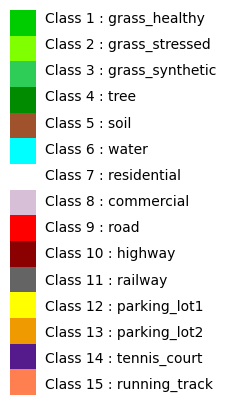

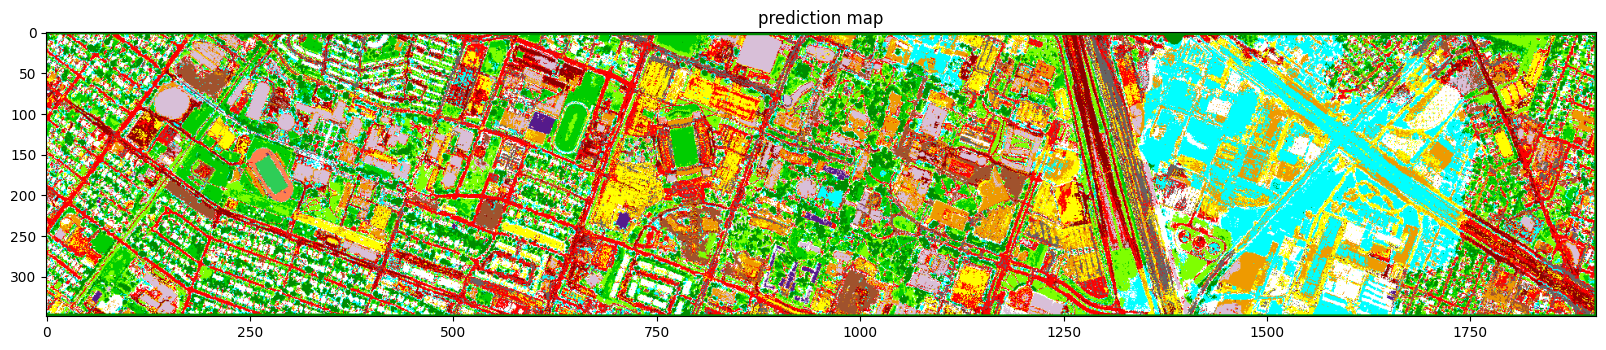

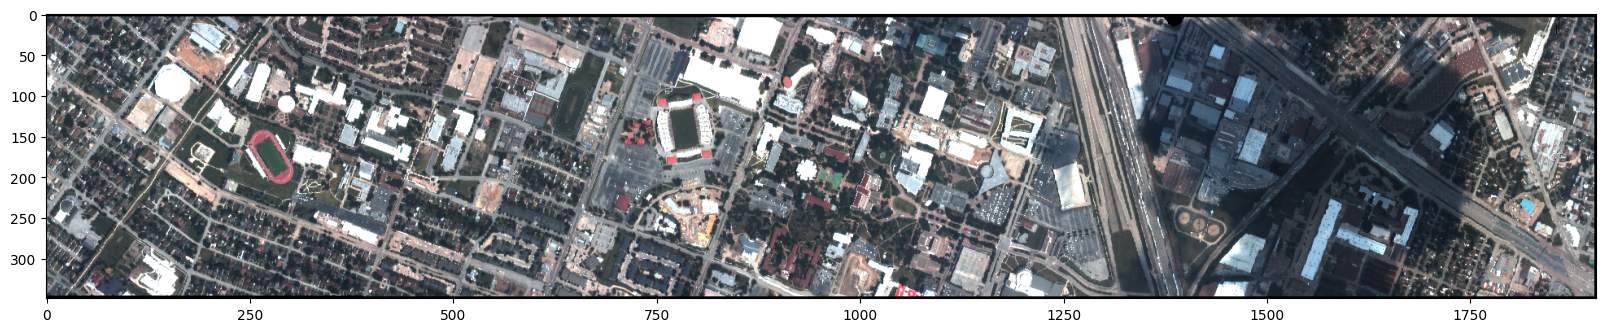

In [10]:
# predict for the whole image
prediction = classifier.predict(allData)
predictionRgb = np.zeros(shape=(prediction.shape[0], 3))

cls_rgb = []
for ii in groundtruth_info:
    cls_rgb.append(ii['class_color'])
cls_rgb = np.array(cls_rgb).reshape(15,-1,3)
plt.figure(figsize=(5,5))
plt.imshow(cls_rgb)
plt.axis('off')
for cls in range(15):
        plt.text(0.85,1.02*cls,'Class %d : %s'%(cls+1,groundtruth_info[cls]['class_name']))
plt.show()

for i in range(len(prediction)):
    predictionRgb[i] = cls_rgb[prediction[i]-1]
predictionRgb = predictionRgb.astype(np.uint)

plt.figure(figsize=(20,5))
plt.title('prediction map')
plt.imshow(predictionRgb.reshape((349,1905,3)))
plt.show()

plt.figure(figsize=(20,5))
plt.imshow(hsi_rgb_pimped)
plt.show()